## Tools and Imports

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor
import seaborn as sns

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

## Dataset

In [77]:
stockData = pd.read_csv("ML_Data2.csv")
stockData.head(8)

,Player,Game,Team,Hero,Stat,Role,Best Attribute,Actual Result
0,1,1.0,1,95,1.0,0,0.0,1
1,2,1.0,1,28,1.0,1,1.0,1
2,3,1.0,1,26,0.0,2,0.0,1
3,4,1.0,1,30,0.0,3,2.0,1
4,5,1.0,2,95,1.0,0,0.0,0
5,6,1.0,2,47,0.0,3,1.0,0
6,7,1.0,2,20,1.0,5,0.0,0
7,8,1.0,2,9,0.0,1,1.0,0


## Basic EDA

before we can proceed to our Naive Bayes, we must confirm that the features we have are independent and are not correlated.

<AxesSubplot:>

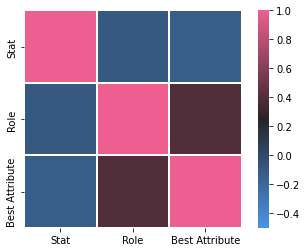

In [78]:
corr = stockData.iloc[:,4:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

## Calculate Prior P(Y)
Logic for this would be P(Y) = totalY/totalN; Y = Win | Lose

In [79]:
def calculate_prior(training_d,Y):
    classes = sorted(list(training_d[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(training_d[training_d[Y]==i])/len(training_d))
    return prior

## Calculate P(X|Y) 
logic here is P(X|Y) = totalX/totalN; X = x0 | x1 | x2 (columns)

In [80]:
def calculate_likelihood(training_d, feat_name, feat_val, Y, label):
    training_d = training_d[training_d[Y]==label]
    p_x_given_y = len(training_d[training_d[feat_name]==feat_val]) / len(training_d)
    return p_x_given_y

## Calculate Probability P(X1|Y)P(X2|Y)P(X3|Y)...P(Xn|Y) * P(Y)

In [81]:
def naive_bayes_categorical(training_data, X, Y):
    #getting the feature names
    features = list(training_data.columns)[4:-1]
    
    prior = calculate_prior(training_data, Y)
    
    probW = []
    probL = []
    Ypred = []
    data = [[],[],[]]
    accumulatedP = [],[]
    for x in X:
        
        labels = sorted(list(training_data[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            #calculate P(X1|Y)P(X2|Y)P(X3|Y)...P(Xn|Y)
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood(training_data, features[i], x[i], Y, labels[j])
        post_prob = [1]*len(labels)
        
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]
               
    
        Ypred.append(np.argmax(post_prob))
        probW.append(post_prob[1])
        probL.append(post_prob[0])
    
    #Since there are 4 heroes per team, their probability are all multiplied
    for i in range(floor(len(X)/4)):
           accumulatedP[1].append(probW[i*4]*probW[(i*4)+1]*probW[(i*4)+2]*probW[(i*4)+3]) 
           accumulatedP[0].append(probL[i*4]*probL[(i*4)+1]*probL[(i*4)+2]*probL[(i*4)+3])
           # We predict win if their win prob is greater than their lose prob.
           if(accumulatedP[1][i] >= accumulatedP[0][i]):
               data[2].append(1)
           else:
               data[2].append(0)

    data[0] = accumulatedP[0]
    data[1] = accumulatedP[1]
    
    return data
        

## Testing For NB

In [82]:

from sklearn.model_selection import train_test_split
train, test = train_test_split(stockData, test_size=.3, shuffle=False)
X_test = test.iloc[:,4:-1].values
Y_test = test.iloc[:,-1].values

Ypred = naive_bayes_categorical(train, X=X_test, Y="Actual Result")

match_y =[]
for i in range(floor(len(X_test)/4)):
    match_y.append(Y_test[i*4])

result = pd.DataFrame({"Prediction":Ypred[2],"Win Probability": Ypred[1], "Lose Probability": Ypred[0],"Actual Result":match_y})

# Calculate Accuracy by the total correct predictions divided by the total Matches
acc = np.sum(result["Prediction"] == result["Actual Result"]) / len(result["Actual Result"])
print_full(result)
print("Accuracy: ", acc)



[[1. 1. 1.]
 [0. 4. 1.]
 [1. 5. 2.]
 ...
 [0. 4. 1.]
 [0. 0. 0.]
 [0. 5. 2.]]
[1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0
 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0
 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0
 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0
 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0
 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1
 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0
 1 1 1 1 1 1 1 1 0 0 0